# Import all the necessary libraries.

In [47]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import preprocess_string
from gensim import corpora
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
from tabulate import tabulate

# Summary

## We have our data distributed across three distinct CSV files: one holding comprehensive show information, another housing critic reviews, and the last containing audience feedback. Our objective is to meticulously examine the data within each CSV file.

## Subsequently, we'll merge the datasets into two distinct dataframes: one combining critic reviews with show details, and the other intertwining audience reviews with show specifics. These two dataframes will be pivotal for our future analysis, hence we'll export them for utilization in subsequent notebooks.


# Let's go.!!! SUUIIIIIIIIII....

# Read the CSV file containing all the shows and Analyse the data. 

In [4]:
df3_tv_shows = pd.read_csv("D:/Spring 2024 notes/Social Media Analytics/SMA_Project/tv_show_links.csv")
print(df3_tv_shows)

       Network              Show Critic Score Audience Score  \
0    Apple TV+              Loot          80%            65%   
1    Apple TV+   For All Mankind          91%            83%   
2    Apple TV+         Severance          97%            93%   
3    Apple TV+     Shining Girls          83%            88%   
4    Apple TV+            Tehran          94%            91%   
..         ...               ...          ...            ...   
880       VUDU          Mr. Bean         100%            92%   
881       VUDU          Preacher          87%            75%   
882       VUDU    House of Cards          77%            76%   
883       VUDU          Hannibal          92%            94%   
884       VUDU  Mare of Easttown          95%            94%   

                                               tv_link  
0               https://www.rottentomatoes.com/tv/loot  
1    https://www.rottentomatoes.com/tv/for_all_mankind  
2          https://www.rottentomatoes.com/tv/severance  
3  

## Data Exploration.

### Shape of the dataset. 

In [5]:
df3_tv_shows.shape

(885, 5)

### Observing the unique values in the "Network" column.

In [6]:
unique_shows = df3_tv_shows['Network'].unique()
print(unique_shows)

['Apple TV+' 'Paramount+' 'HBO MAX' 'Disney+' 'Prime Video' 'Hulu'
 'Netflix' 'Peacock' 'VUDU']


### Unique value counts of "Network" column. 

In [7]:
categorical_columns = ['Network']
for col in categorical_columns:
    print(f"\nValue counts in '{col}':")
    print(df3_tv_shows[col].value_counts()) 
    print("\n")


Value counts in 'Network':
Paramount+     100
HBO MAX        100
Disney+        100
Prime Video    100
Hulu           100
Netflix        100
Peacock        100
VUDU           100
Apple TV+       85
Name: Network, dtype: int64




### Column Analysis. 

In [8]:
print("\nColumns and Data Types:")
print(df3_tv_shows.dtypes)


Columns and Data Types:
Network           object
Show              object
Critic Score      object
Audience Score    object
tv_link           object
dtype: object


### Drop unnecessary columns. Here, we can see that the link column, doesn't affect the dataset in any way. So we can drop it.  

In [9]:
df3_tv_shows = df3_tv_shows.drop(columns=['tv_link'])
print(df3_tv_shows.head())

     Network             Show Critic Score Audience Score
0  Apple TV+             Loot          80%            65%
1  Apple TV+  For All Mankind          91%            83%
2  Apple TV+        Severance          97%            93%
3  Apple TV+    Shining Girls          83%            88%
4  Apple TV+           Tehran          94%            91%


In [10]:
# Group the DataFrame by 'Show' and count the number of unique platforms
platform_count = df3_tv_shows.groupby('Show')['Network'].nunique()

# Filter the shows where the count of unique platforms is greater than 1
shows_on_multiple_platforms = platform_count[platform_count > 1]

# Get the number of shows on multiple platforms
num_shows_on_multiple_platforms = len(shows_on_multiple_platforms)

# Print the result
print("Number of shows streamed on multiple platforms:", num_shows_on_multiple_platforms)

# Print the list of shows and the number of platforms they are streamed on
print("\nShows streamed on multiple platforms:")
print(shows_on_multiple_platforms)

Number of shows streamed on multiple platforms: 120

Shows streamed on multiple platforms:
Show
13 Reasons Why               3
Adventure Time               2
All American                 3
Altered Carbon               3
American Horror Story        3
                            ..
What We Do in the Shadows    3
Yellowjackets                3
Yellowstone                  3
You                          3
Young Sheldon                2
Name: Network, Length: 120, dtype: int64


### Missing values.

In [11]:
print("\nMissing Values:")
print(df3_tv_shows.isnull().sum())


Missing Values:
Network           0
Show              0
Critic Score      0
Audience Score    0
dtype: int64


### Summary Statistics.

In [12]:
print("\nSummary Statistics:")
print(df3_tv_shows.describe())


Summary Statistics:
           Network     Show Critic Score Audience Score
count          885      885          885            885
unique           9      685           67             71
top     Paramount+  Vikings           --             --
freq           100        4          171             66


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Read the CSV file containing all the critic reviews and analyse the data. 

In [13]:
df2_critics = pd.read_csv("D:/Spring 2024 notes/Social Media Analytics/SMA_Project/critic_reviews.csv")
print(df2_critics)

                   Show  Sentiment  \
0      Mare of Easttown          1   
1      Mare of Easttown          1   
2      Mare of Easttown          1   
3      Mare of Easttown          1   
4      Mare of Easttown          1   
...                 ...        ...   
14786  The Defiant Ones          1   
14787  The Defiant Ones          1   
14788  The Defiant Ones          1   
14789  The Defiant Ones          1   
14790  The Defiant Ones          1   

                                                  Review  
0      I’m not sure I have engaged in appointment vie...  
1      Kate is marvelous; she truly is Mare. She disa...  
2      That’s the thing I’ve loved most about Mare: t...  
3      Boasting Kate Winslet in the title role, twist...  
4      Performances in which madness, psychopathy or ...  
...                                                  ...  
14786  Hughes tries to weave in a number of larger st...  
14787  It's the decades of struggle and successes lea...  
14788  It's 

## Data Exploration.

### Shape of the dataset. 

In [14]:
df2_critics.shape

(14791, 3)

### Column Analysis

In [15]:
print("\nColumns and Data Types:")
print(df2_critics.dtypes)


Columns and Data Types:
Show         object
Sentiment     int64
Review       object
dtype: object


### Analysing the Sentiment Distribution 

In [16]:
print("\nSentiment Value Distribution:")
print(df2_critics['Sentiment'].value_counts(normalize=True))


Sentiment Value Distribution:
1    0.845447
0    0.154553
Name: Sentiment, dtype: float64


### Unique value and unique count in the dataset. 

In [17]:
unique_critic_reviews = df2_critics['Review'].unique()
print(unique_critic_reviews)

['I’m not sure I have engaged in appointment viewing in years! It was nice to be giddy on a Sunday night for m’stories.'
 'Kate is marvelous; she truly is Mare. She disappears into this role!'
 'That’s the thing I’ve loved most about Mare: the general feeling of excitement and, dare I say, fandom...'
 ...
 "It's a wild, vivid, perceptive ride into a world as glamorous as it is ugly."
 'Hughes artfully maintains a sense of awe and tension that vibrates throughout every chapter.'
 "It's boilerplate Great American Dream-type stuff, but it works."]


In [18]:
unique_critic_reviews_count = df2_critics['Review'].nunique()
print("Number of unique reviews:",unique_critic_reviews_count)

Number of unique reviews: 14789


### Missing values in the dataset. 

In [19]:
print("\nMissing Values:")
print(df2_critics.isnull().sum())


Missing Values:
Show         0
Sentiment    0
Review       1
dtype: int64


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Merging the critic reviews with the shows. 

In [20]:
# Merge critic reviews with TV shows data based on 'Show' column
merged_critic_df = pd.merge(df2_critics, df3_tv_shows, on='Show', how='inner')

# Get unique networks
networks_list_critic = merged_critic_df['Network'].unique()

# Group by 'Show' and 'Network' and count the number of reviews for each combination
critic_review_counts = merged_critic_df.groupby(['Show', 'Network']).size()

# Reset index to make the groupby results a DataFrame
critic_review_counts = critic_review_counts.reset_index(name='Critic Review Count')

# Merge back with the merged DataFrame to add the critic review count for each show and network
merged_critic_df = pd.merge(merged_critic_df, critic_review_counts, on=['Show', 'Network'], how='left')

# Concatenate the merged DataFrame with the result DataFrame from each network
result_critic_df = pd.concat([merged_critic_df[merged_critic_df['Network'] == network] for network in networks_list_critic])

# Reset index for the final DataFrame
result_critic_df.reset_index(drop=True, inplace=True)

In [21]:
print(result_critic_df.head())

               Show  Sentiment  \
0  Mare of Easttown          1   
1  Mare of Easttown          1   
2  Mare of Easttown          1   
3  Mare of Easttown          1   
4  Mare of Easttown          1   

                                              Review  Network Critic Score  \
0  I’m not sure I have engaged in appointment vie...  HBO MAX          95%   
1  Kate is marvelous; she truly is Mare. She disa...  HBO MAX          95%   
2  That’s the thing I’ve loved most about Mare: t...  HBO MAX          95%   
3  Boasting Kate Winslet in the title role, twist...  HBO MAX          95%   
4  Performances in which madness, psychopathy or ...  HBO MAX          95%   

  Audience Score  Critic Review Count  
0            94%                  127  
1            94%                  127  
2            94%                  127  
3            94%                  127  
4            94%                  127  


### Checking the dimensions of the newly created dataset. 

In [22]:
print("Dimensions of result DataFrame:", result_critic_df.shape)

Dimensions of result DataFrame: (19789, 7)


### Check for missing values. 

In [23]:
missing_values = result_critic_df.isnull().sum()
print("\nMissing values:\n", missing_values)


Missing values:
 Show                   0
Sentiment              0
Review                 1
Network                0
Critic Score           0
Audience Score         0
Critic Review Count    0
dtype: int64


### Inspecting the row with the missing values. 

In [24]:
rows_with_missing_values = result_critic_df[result_critic_df.isnull().any(axis=1)]
print("Rows with missing values:\n", rows_with_missing_values)

Rows with missing values:
            Show  Sentiment Review    Network Critic Score Audience Score  \
6671  WeCrashed          0    NaN  Apple TV+          65%            78%   

      Critic Review Count  
6671                   46  


### Dropping the missing value. 

In [25]:
# Drop rows with missing values
result_critic_df.dropna(inplace=True)

# Confirm that missing values have been dropped
missing_values_after_drop = result_critic_df.isnull().sum()
print("Missing values after dropping rows:\n", missing_values_after_drop)

Missing values after dropping rows:
 Show                   0
Sentiment              0
Review                 0
Network                0
Critic Score           0
Audience Score         0
Critic Review Count    0
dtype: int64


### Inspecting random data samples.

In [26]:
print("\nSample of the resulting DataFrame:")
print(result_critic_df.sample(5))


Sample of the resulting DataFrame:
                       Show  Sentiment  \
7658         Little America          1   
8662     Star Trek: Prodigy          1   
17299  Parks and Recreation          1   
18670               Hawkeye          1   
13788       Behind Her Eyes          1   

                                                  Review     Network  \
7658   "Little America" is a relevant and essential s...   Apple TV+   
8662   Might make some parents smile... My 7-year-old...  Paramount+   
17299  It's fun. I loved it. Spending 30 minutes visi...     Peacock   
18670  Steinfeld brings a charm and strong will to Ka...     Disney+   
13788  "Behind Her Eyes" isn't about people, really. ...     Netflix   

      Critic Score Audience Score  Critic Review Count  
7658           95%            79%                   38  
8662           93%            73%                   15  
17299          93%            89%                   26  
18670          92%            91%                 

### Checking the review counts for each Network. 

In [27]:
review_counts_check = result_critic_df.groupby(['Show', 'Network'])['Review'].count()
print("\nReview counts for each show and network combination:")
print(review_counts_check)


Review counts for each show and network combination:
Show              Network    
11.22.63          Hulu           64
13 Reasons Why    Netflix        12
                  Prime Video    12
                  VUDU           12
1883              Paramount+     24
                                 ..
You're the Worst  Hulu           13
Young Justice     HBO MAX         2
Younger           Paramount+     14
black-ish         Disney+         1
iCarly            Paramount+      6
Name: Review, Length: 669, dtype: int64


## Export the dataframe to CSV file. 

In [36]:
result_critic_df.to_csv('D:/Spring 2024 notes/Social Media Analytics/SMA_Project/ModifiedCritic.csv')

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

# Read the CSV file containing the audience reviews and analyse the data. 

In [30]:
df1_audience = pd.read_csv("D:/Spring 2024 notes/Social Media Analytics/SMA_Project/audience_reviews.csv")
print(df1_audience)

       Show  Rating                                             Review
0      Test     0.0                                        Test review
1      Loot     2.5  I love the stars, but the show is riddled with...
2      Loot     4.5  Great show to watch. It's something that's eas...
3      Loot     0.5  Another Apple tanker crashes into the reef wit...
4      Loot     4.5  This is such a fun, endearing show.  It has a ...
...     ...     ...                                                ...
65517  Rise     5.0                         outstanding and inspiring.
65518  Rise     2.5  Having spent 43 years in public schools and ne...
65519  Rise     0.5  why did they have to put rap in the show? If y...
65520  Rise     5.0  keep it up!!! NETWORK TV!! Shows like this and...
65521  Rise     1.5  Considering the plot, its suprisingly offensiv...

[65522 rows x 3 columns]


## Data Exploration.

### Shape of the dataset.

In [31]:
df1_audience.shape

(65522, 3)

### Column analysis. 

In [32]:
print("\nColumns and Data Types:")
print(df1_audience.dtypes)


Columns and Data Types:
Show       object
Rating    float64
Review     object
dtype: object


### summary Statistics.

In [33]:
print("\nSummary Statistics for Rating:")
print(df1_audience['Rating'].describe())


Summary Statistics for Rating:
count    65522.000000
mean         3.514659
std          1.738253
min          0.000000
25%          2.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64


### Checking for missing values. 

In [34]:
print("\nMissing Values:")
print(df1_audience.isnull().sum())


Missing Values:
Show      0
Rating    0
Review    0
dtype: int64


### Plotting the rating distribution. 

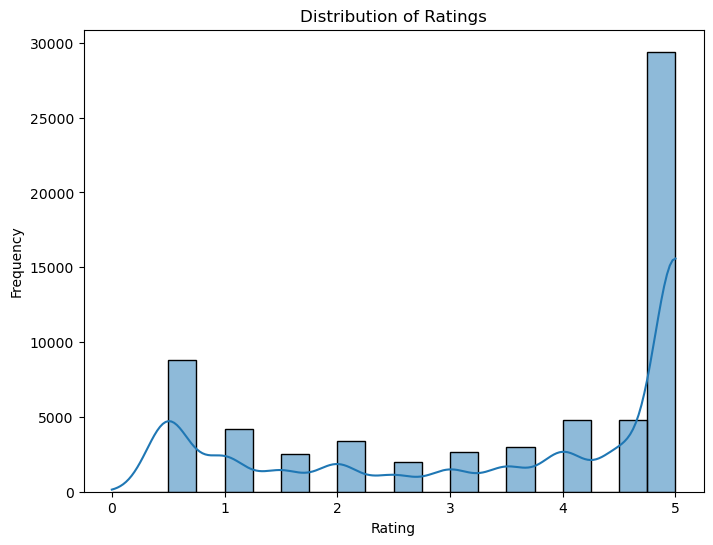

In [35]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df1_audience, x='Rating', bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Merging the audience reviews with the shows.

In [36]:
# Merge audience reviews with TV shows data based on 'Show' column
merged_audience_df = pd.merge(df1_audience, df3_tv_shows, on='Show', how='inner')

networks_list = merged_audience_df['Network'].unique()

# Group by 'Show' and 'Network' and count the number of reviews for each combination
review_counts = merged_audience_df.groupby(['Show', 'Network']).size()

# Reset index to make the groupby results a DataFrame
review_counts = review_counts.reset_index(name='Review Count')

# Merge back with the merged DataFrame to add the review count for each show and network
merged_audience_df = pd.merge(merged_audience_df, review_counts, on=['Show', 'Network'], how='left')

# Concatenate the merged DataFrame with the result DataFrame from each network
result_audience_df = pd.concat([merged_audience_df[merged_audience_df['Network'] == network] for network in networks_list])

# Reset index for the final DataFrame
result_audience_df.reset_index(drop=True, inplace=True)

In [37]:
print(result_audience_df)

                                 Show  Rating  \
0                                Loot     2.5   
1                                Loot     4.5   
2                                Loot     0.5   
3                                Loot     4.5   
4                                Loot     0.5   
...                               ...     ...   
93190  Once Upon a Time in Wonderland     5.0   
93191  Once Upon a Time in Wonderland     2.5   
93192  Once Upon a Time in Wonderland     2.0   
93193  Once Upon a Time in Wonderland     5.0   
93194  Once Upon a Time in Wonderland     5.0   

                                                  Review    Network  \
0      I love the stars, but the show is riddled with...  Apple TV+   
1      Great show to watch. It's something that's eas...  Apple TV+   
2      Another Apple tanker crashes into the reef wit...  Apple TV+   
3      This is such a fun, endearing show.  It has a ...  Apple TV+   
4      Terrible show - didn't laugh once. Acting is s...

### Checking the unique values in the "Network" column. 

In [38]:
print(result_audience_df['Network'].unique())

['Apple TV+' 'Paramount+' 'Prime Video' 'VUDU' 'Netflix' 'Hulu' 'Peacock'
 'HBO MAX' 'Disney+']


### Checking the dimensions of the newly created dataset.

In [39]:
print("Dimensions of result DataFrame:", result_audience_df.shape)

Dimensions of result DataFrame: (93195, 7)


### Check for missing values.

In [40]:
missing_values = result_audience_df.isnull().sum()
print("\nMissing values:\n", missing_values)


Missing values:
 Show              0
Rating            0
Review            0
Network           0
Critic Score      0
Audience Score    0
Review Count      0
dtype: int64


### Inspecting random data samples.

In [41]:
print("\nSample of the resulting DataFrame:")
print(result_audience_df.sample(5))


Sample of the resulting DataFrame:
                            Show  Rating  \
55750  Dead End: Paranormal Park     5.0   
92608                       Glee     5.0   
80998                Moon Knight     5.0   
62899                 The Office     0.5   
85185                       Loki     4.0   

                                                  Review  Network  \
55750  Great show! It has amazing gay, autistic and t...  Netflix   
92608                               I miss this show....  Disney+   
80998  Moon Knight is definitely one of the best, if ...  Disney+   
62899  So Bad,  Ricky Gervais is a cruel sadistic tro...  Peacock   
85185  Growth is painful.  Trust is hard.  Realizing ...  Disney+   

      Critic Score Audience Score  Review Count  
55750         100%            76%            19  
92608          70%            71%            36  
80998          86%            91%          1164  
62899          81%            89%           244  
85185          92%            91% 

### Checking the review counts for each Network.

In [42]:
review_counts_check = result_audience_df.groupby(['Show', 'Network'])['Review'].count()
print("\nReview counts for each show and network combination:")
print(review_counts_check)


Review counts for each show and network combination:
Show               Network    
11.22.63           Hulu           160
13 Reasons Why     Netflix        265
                   Prime Video    265
                   VUDU           265
1883               Paramount+     200
                                 ... 
You Don't Know Me  Netflix          4
You're the Worst   Hulu             9
Young Justice      HBO MAX         83
Younger            Paramount+       8
iCarly             Paramount+       6
Name: Review, Length: 742, dtype: int64


## Keyword analysis in Audience reviews.

In [55]:
def extract_keywords(reviews, n=10):
    vec = CountVectorizer(stop_words='english').fit(reviews)
    bag_of_words = vec.transform(reviews)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

high_rating_reviews = result_audience_df[result_audience_df['Rating'] >= 4]['Review']
low_rating_reviews = result_audience_df[result_audience_df['Rating'] <= 2]['Review']

high_rating_keywords = extract_keywords(high_rating_reviews)
low_rating_keywords = extract_keywords(low_rating_reviews)

print("Top 10 Keywords in High Rating Reviews:")
print(tabulate(high_rating_keywords, headers=['Keyword', 'Frequency'], tablefmt='grid'))
print("\nTop 10 Keywords in Low Rating Reviews:")
print(tabulate(low_rating_keywords, headers=['Keyword', 'Frequency'], tablefmt='grid'))


Top 10 Keywords in High Rating Reviews:
+------------+-------------+
| Keyword    |   Frequency |
+============+=============+
| season     |       22615 |
+------------+-------------+
| series     |       14985 |
+------------+-------------+
| great      |       11968 |
+------------+-------------+
| best       |       10111 |
+------------+-------------+
| story      |        9242 |
+------------+-------------+
| good       |        8987 |
+------------+-------------+
| like       |        8496 |
+------------+-------------+
| characters |        8064 |
+------------+-------------+
| episode    |        7894 |
+------------+-------------+
| just       |        7852 |
+------------+-------------+

Top 10 Keywords in Low Rating Reviews:
+------------+-------------+
| Keyword    |   Frequency |
+============+=============+
| season     |       19659 |
+------------+-------------+
| just       |       11397 |
+------------+-------------+
| like       |        9481 |
+------------+-------

## Statistical Analysis on Review Length and Rating. 

In [61]:
result_audience_df['Review Length'] = result_audience_df['Review'].apply(len)

# Tabulate the correlation coefficient
print("\nCorrelation Coefficient Table:")
print(tabulate(correlation, headers='keys', tablefmt='grid'))


Correlation Coefficient Table:
+---------------+-----------------+------------+
|               |   Review Length |     Rating |
+===============+=================+============+
| Review Length |       1         | -0.0938893 |
+---------------+-----------------+------------+
| Rating        |      -0.0938893 |  1         |
+---------------+-----------------+------------+


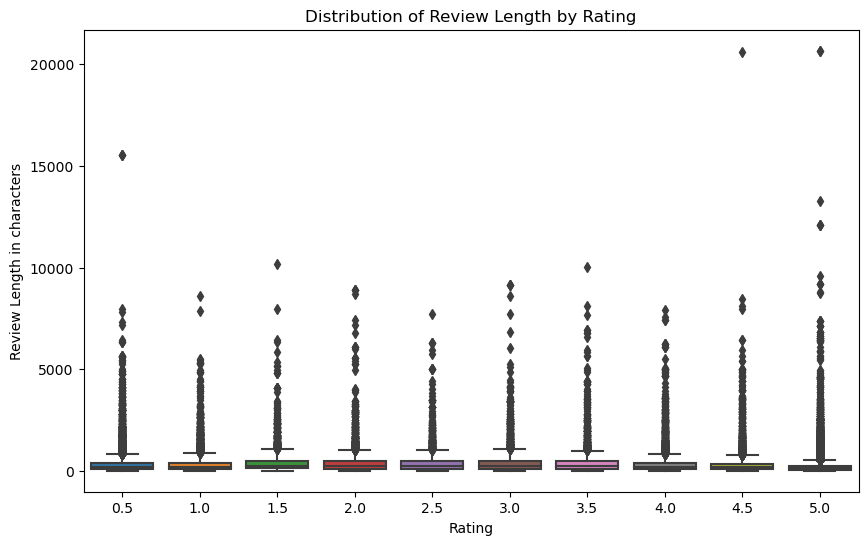

In [63]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating', y='Review Length', data=result_audience_df)
plt.title('Distribution of Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length in characters')
plt.show()

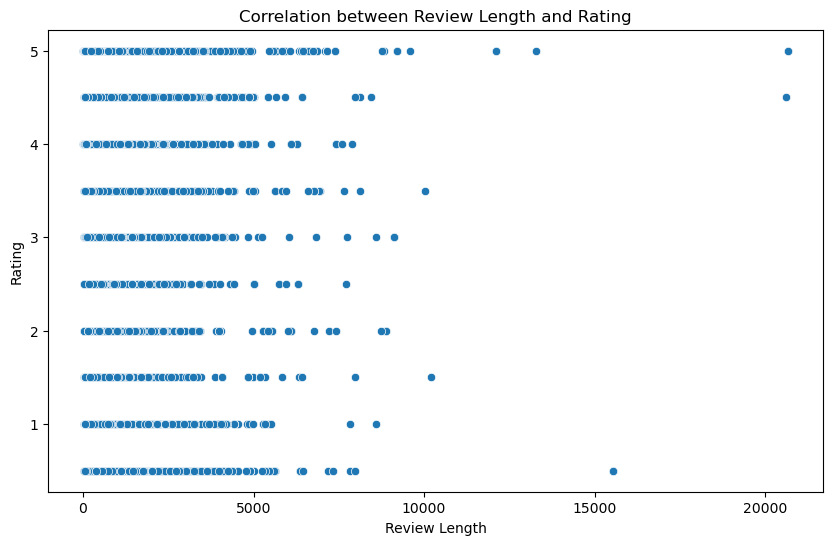

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Review Length', y='Rating', data=result_audience_df)
plt.title('Correlation between Review Length and Rating')
plt.show()


## Export the dataframe to CSV file.

In [56]:
result_audience_df.to_csv('D:/Spring 2024 notes/Social Media Analytics/SMA_Project/ModifiedAudience.csv')

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------